<a href="https://colab.research.google.com/github/nikhil-xyz/Imdb-Sentiment-Analysis/blob/main/Imdb_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
! git clone https://github.com/nikhil-xyz/Imdb-Sentiment-Analysis.git

fatal: destination path 'Imdb-Sentiment-Analysis' already exists and is not an empty directory.


In [47]:
import pandas as pd

In [48]:
data = pd.read_csv('/content/Imdb-Sentiment-Analysis/Train.csv')

In [49]:
data.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [50]:
data.shape

(40000, 2)

In [51]:
data.isnull().sum()

text     0
label    0
dtype: int64

In [52]:
list(data.groupby('label'))

[(0,                                                     text  label
  0      I grew up (b. 1965) watching and loving the Th...      0
  1      When I put this movie in my DVD player, and sa...      0
  2      Why do people who do not know what a particula...      0
  3      Even though I have great interest in Biblical ...      0
  5      A terrible movie as everyone has said. What ma...      0
  ...                                                  ...    ...
  39984  I couldn't relate to this film. It failed to e...      0
  39985  Comedy? What's so funny about watching an ugly...      0
  39993  "The Best Movie of the 90's" "The Welsh Trains...      0
  39994  My girlfriend has the habit of going to Blockb...      0
  39997  My wife and I watched this movie because we pl...      0
  
  [20019 rows x 2 columns]),
 (1,                                                     text  label
  4      Im a die hard Dads Army fan and nothing will e...      1
  6      Finally watched this shocking

In [53]:
# removing panctuations
import string
data['text'] = data['text'].apply(lambda word:[letters.lower() for letters in word if letters not in string.punctuation])
data['text'] = data['text'].apply(lambda word:''.join(word))

In [54]:
data

,text,label
0,i grew up b 1965 watching and loving the thund...,0
1,when i put this movie in my dvd player and sat...,0
2,why do people who do not know what a particula...,0
3,even though i have great interest in biblical ...,0
4,im a die hard dads army fan and nothing will e...,1
...,...,...
39995,western union is something of a forgotten clas...,1
39996,this movie is an incredible piece of work it e...,1
39997,my wife and i watched this movie because we pl...,0
39998,when i first watched flatliners i was amazed i...,1


In [55]:
# import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer

In [56]:
# stops = set(stopwords.words('english'))
# stops.remove('no')
# stops.remove('not')
# stops

In [57]:
# wnl = WordNetLemmatizer()
# def preprocess(text):
#   text = text.lower()
#   text = text.split()
#   text = [wnl.lemmatize(word) for word in text if not word in stopwords.words('english')]
#   text = ' '.join(text)
#   return text

In [58]:
# data['text'] = data['text'].apply(preprocess)

In [59]:
data.iloc[0]['text']

'i grew up b 1965 watching and loving the thunderbirds all my mates at school watched we played thunderbirds before school during lunch and after school we all wanted to be virgil or scott no one wanted to be alan counting down from 5 became an art form i took my children to see the movie hoping they would get a glimpse of what i loved as a child how bitterly disappointing the only high point was the snappy theme tune not that it could compare with the original score of the thunderbirds thankfully early saturday mornings one television channel still plays reruns of the series gerry anderson and his wife created jonatha frakes should hand in his directors chair his version was completely hopeless a waste of film utter rubbish a cgi remake may be acceptable but replacing marionettes with homo sapiens subsp sapiens was a huge error of judgment'

In [60]:
data.iloc[0]['label']

0

In [61]:
import tensorflow as tf

In [62]:
X = data['text']
y = data['label'].values

In [63]:
vocab_size = 70000
from tensorflow.keras.layers import TextVectorization
vectorizer = TextVectorization(max_tokens = vocab_size, output_sequence_length=512, output_mode='int')
vectorizer.adapt(X.values)

In [64]:
vectorized_text = vectorizer(X.values)

In [65]:
vectorized_text.shape

TensorShape([40000, 512])

In [66]:
import pickle
pickle.dump({'config': vectorizer.get_config(),
             'weights': vectorizer.get_weights()}
            , open("vectorizer.pkl", "wb"))

In [67]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(1600)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [68]:
len(dataset)

2500

In [69]:
train = dataset.take(int(len(dataset)*0.7))
val = dataset.skip(int(len(dataset)*0.7)).take(int(len(dataset)*0.2))
test = dataset.skip(int(len(dataset)*0.9)).take(int(len(dataset)*0.1))

In [70]:
train.as_numpy_iterator()

In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, Embedding

In [72]:

embedding_dims = 128
model = Sequential()
model.add(Embedding(vocab_size, embedding_dims))
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

In [73]:
model.compile(optimizer='adam',loss='BinaryCrossentropy', metrics=['accuracy'])

In [74]:
history = model.fit(train, epochs=20, validation_data=val)

Epoch 1/20
1750/1750 [==============================] - 127s 70ms/step - loss: 0.5127 - accuracy: 0.7541 - val_loss: 0.6476 - val_accuracy: 0.6084
Epoch 2/20
1750/1750 [==============================] - 65s 37ms/step - loss: 0.4100 - accuracy: 0.8216 - val_loss: 0.5148 - val_accuracy: 0.7556
Epoch 3/20
1750/1750 [==============================] - 64s 37ms/step - loss: 0.2566 - accuracy: 0.9028 - val_loss: 0.3216 - val_accuracy: 0.8715
Epoch 4/20
1750/1750 [==============================] - 64s 37ms/step - loss: 0.1648 - accuracy: 0.9416 - val_loss: 0.3739 - val_accuracy: 0.8706
Epoch 5/20
1750/1750 [==============================] - 60s 34ms/step - loss: 0.0932 - accuracy: 0.9690 - val_loss: 0.2924 - val_accuracy: 0.8923
Epoch 6/20
1750/1750 [==============================] - 58s 33ms/step - loss: 0.0566 - accuracy: 0.9822 - val_loss: 0.3298 - val_accuracy: 0.8840
Epoch 7/20
1750/1750 [==============================] - 56s 32ms/step - loss: 0.0294 - accuracy: 0.9913 - val_loss: 0.3751 

In [75]:
model.save('model.h5')

In [76]:
# history = (model.predict(test) > 0.5).astype(int)

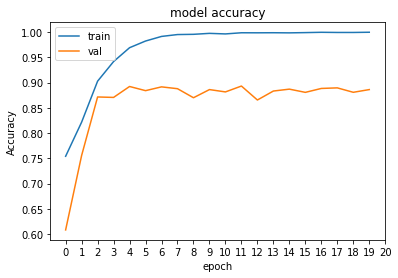

In [78]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xticks([i for i in range(21)])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

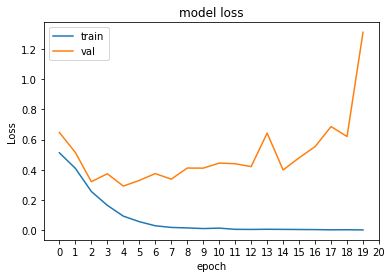

In [79]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xticks([i for i in range(21)])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# prediction metrics
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
  X_true, y_true = batch
  yhat = (model.predict(X_true) > 0.5).astype(int)

  y_true = y_true.flatten()
  yhat = yhat.flatten()

  pre.update_state(y_true, yhat)
  re.update_state(y_true, yhat)
  acc.update_state(y_true, yhat)
     

In [ ]:
print("Precision: ",pre.result().numpy())
print("Recall: ", re.result().numpy())
print("Accuracy: ", acc.result().numpy())

In [ ]:
# testing new data
temp = "Stylish, slick and action-packed film; in one work it’s a ‘Blockbuster’. Film has actions, thrills, bit of suspense and gripping storyline. SRK is back with a bang and has made his fans delighted, a long wait proven worthy. John Abraham looks solid in his negative role and DeepikaP looks stunning, and she has also done some actions in the film along with flourishing her beauty. All the fight sequences and chases are indeed marvelously picturized plus they are very captivating. Full marks to the VFX and CGI as well with that."
temp

In [ ]:
# Removing punctuations using replace() method
exclude = set(string.punctuation)
temp_x = ''.join(ch for ch in temp if ch not in exclude)
temp_x = temp_x.lower()
temp_x = temp_x.split()
temp_x = [wnl.lemmatize(word) for word in temp_x if not word in stopwords.words('english')]
temp_x = ' '.join(temp_x)

In [ ]:
temp_x

In [ ]:
temp_x = vectorizer(temp_x)
temp_x

In [ ]:
import numpy as np
(model.predict(np.expand_dims(temp_x, 0)) > 0.5).astype('int')[0][0]